In [1]:
from hazm.Embedding import SentEmbedding, WordEmbedding
from hazm import PersicaReader, word_tokenize, POSTagger, Normalizer
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
persikaReader = PersicaReader('/repo/ebi/persica/persica.csv')

In [3]:
word2vec = WordEmbedding(model_path='/repo/ebi/embedding/training_files/fasttextV2_skipgram_dim300_epoch30_naabData0to35.bin',
                        model_type='fasttext')

tcmalloc: large alloc 5128601600 bytes == 0xee94000 @ 
tcmalloc: large alloc 2728599552 bytes == 0x1409be000 @ 
tcmalloc: large alloc 2728599552 bytes == 0x1ecc78000 @ 
tcmalloc: large alloc 2400002048 bytes == 0x28f6aa000 @ 
tcmalloc: large alloc 2728599552 bytes == 0x32cd50000 @ 


In [4]:
sent2vec = SentEmbedding('/repo/ebi/embedding/training_files/trained_models/sent2vec/sent2vec-naab.model')

In [5]:
tqdm.pandas()
data = pd.DataFrame([[item['text'], item['category2']] for item in persikaReader.docs()],
                    columns = ['text', 'category'])

data = data[data['text'] != ''].reset_index(drop = True)
data

,text,category
0,وزير علوم در جمع استادان نمونه كشور گفت: از اس...,آموزشي
1,به گزارش سرويس صنفي آموزشي خبرگزاري دانشجويان ...,آموزشي
2,نتايج آزمون دوره‌هاي فراگير مقاطع كارشناسي و ك...,آموزشي
3,محمدتقي علوي يزدي، مجري اين طرح پژوهشي در اين‌...,آموزشي
4,دوره آموزشي سيره نبوي بعنوان يكي از رشته‌هاي ج...,آموزشي
...,...,...
10983,به گزارش ايسنا، در كوران مسابقات دوچرخه سواري ...,ورزشي
10984,محمد دليريان در گفت‌وگو با خبرنگار كشتي خبرگزا...,ورزشي
10985,به گزارش خبرگزاري دانشجويان ايران (ايسنا)، در ...,ورزشي
10986,به گزارش خبرگزاري دانشجويان ايران (ايسنا)، اير...,ورزشي


In [6]:
data['category'].value_counts()

آموزشي        1000
اقتصادي       1000
بهداشتي       1000
مذهبي         1000
اجتماعي        999
فرهنگي         999
ورزشي          999
تاريخي         998
سياسي          998
فقه و حقوق     998
علمي           997
Name: category, dtype: int64

In [7]:
labels = data['category'].unique()
d = dict(zip(labels, range(len(labels))))
data['label'] = data['category'].map(d)
data

,text,category,label
0,وزير علوم در جمع استادان نمونه كشور گفت: از اس...,آموزشي,0
1,به گزارش سرويس صنفي آموزشي خبرگزاري دانشجويان ...,آموزشي,0
2,نتايج آزمون دوره‌هاي فراگير مقاطع كارشناسي و ك...,آموزشي,0
3,محمدتقي علوي يزدي، مجري اين طرح پژوهشي در اين‌...,آموزشي,0
4,دوره آموزشي سيره نبوي بعنوان يكي از رشته‌هاي ج...,آموزشي,0
...,...,...,...
10983,به گزارش ايسنا، در كوران مسابقات دوچرخه سواري ...,ورزشي,10
10984,محمد دليريان در گفت‌وگو با خبرنگار كشتي خبرگزا...,ورزشي,10
10985,به گزارش خبرگزاري دانشجويان ايران (ايسنا)، در ...,ورزشي,10
10986,به گزارش خبرگزاري دانشجويان ايران (ايسنا)، اير...,ورزشي,10


In [8]:
from collections import defaultdict
from sklearn import metrics

evaluations = []
evaluations_std = []


def fit_and_evaluate(km, X, labels, name=None, n_runs=5):
    scores = defaultdict(list)
    for seed in range(n_runs):
        km.set_params(random_state=seed)
        km.fit(X)
        scores["Homogeneity"].append(metrics.homogeneity_score(labels, km.labels_))
        scores["Completeness"].append(metrics.completeness_score(labels, km.labels_))
        scores["V-measure"].append(metrics.v_measure_score(labels, km.labels_))
        scores["Adjusted Rand-Index"].append(
            metrics.adjusted_rand_score(labels, km.labels_)
        )
        scores["Silhouette Coefficient"].append(
            metrics.silhouette_score(X, km.labels_, sample_size=2000)
        )
        
    evaluation = {
        "estimator": name,
    }
    evaluation_std = {
        "estimator": name,
    }
    for score_name, score_values in scores.items():
        mean_score, std_score = np.mean(score_values), np.std(score_values)
        print(f"{score_name}: {mean_score:.3f} ± {std_score:.3f}")
        evaluation[score_name] = mean_score
        evaluation_std[score_name] = std_score
    evaluations.append(evaluation)
    evaluations_std.append(evaluation_std)

In [9]:
kmeans = KMeans(
    n_clusters=len(labels),
    n_init=5
)

fit_and_evaluate(kmeans, [sent2vec[item] for item in data['text']], labels=list(data['label']), name="KMeans on sent2vec")


Homogeneity: 0.129 ± 0.020
Completeness: 0.171 ± 0.024
V-measure: 0.147 ± 0.022
Adjusted Rand-Index: 0.038 ± 0.007
Silhouette Coefficient: 0.027 ± 0.019


In [10]:
kmeans = KMeans(
    n_clusters=len(labels),
    n_init=5
)

mean_embed = []
for sent in tqdm(data['text']):
    embeds = [word2vec[word] for word in word_tokenize(sent)]   
    mean_embed.append(np.array(embeds).mean(axis=0))

fit_and_evaluate(kmeans, mean_embed, labels=list(data['label']), name="KMeans on mean of the word2vec")


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10988/10988 [00:45<00:00, 241.93it/s]


Homogeneity: 0.113 ± 0.001
Completeness: 0.135 ± 0.001
V-measure: 0.123 ± 0.001
Adjusted Rand-Index: 0.067 ± 0.001
Silhouette Coefficient: 0.028 ± 0.002


In [11]:
kmeans = KMeans(
    n_clusters=len(labels),
    n_init=5
)

vectorizer = TfidfVectorizer(
    max_df=0.5,
    min_df=5,
)

X_tfidf = vectorizer.fit_transform(data['text'])

fit_and_evaluate(kmeans, X_tfidf, labels=list(data['label']), name="KMeans on TfIdf algourithm")

Homogeneity: 0.408 ± 0.021
Completeness: 0.483 ± 0.023
V-measure: 0.442 ± 0.021
Adjusted Rand-Index: 0.217 ± 0.015
Silhouette Coefficient: 0.010 ± 0.001


In [17]:
kmeans = KMeans(
    n_clusters=len(labels),
    n_init=5
)

# tagger = POSTagger(model='/repo/ebi/folder/postagger.model')
# data['keyWords'] = data['text'].progress_apply(lambda x: ' '.join(embedRank(x, 8, sent2vecModel=sent2vec, posTaggerModel=tagger)))


fit_and_evaluate(kmeans, [sent2vec[item] for item in data['keyWords']], labels=list(data['label']), name="KMeans on embedRank keywordExtraction using sent2vec")


Homogeneity: 0.180 ± 0.004
Completeness: 0.185 ± 0.004
V-measure: 0.183 ± 0.004
Adjusted Rand-Index: 0.098 ± 0.002
Silhouette Coefficient: 0.018 ± 0.002


In [68]:
data

,text,category,label,keyWords
0,وزير علوم در جمع استادان نمونه كشور گفت: از اس...,آموزشي,0,توان استادان مصادیق نخبگان دانشگاه‌ها رویکرد د...
1,به گزارش سرويس صنفي آموزشي خبرگزاري دانشجويان ...,آموزشي,0,فعالیت‌های دانشجویان دانش‌آموختگان سوره انتخاب...
2,نتايج آزمون دوره‌هاي فراگير مقاطع كارشناسي و ك...,آموزشي,0,آزمون مرداد منظور ثبت پذیرفته‌شدگان دوره‌های ا...
3,محمدتقي علوي يزدي، مجري اين طرح پژوهشي در اين‌...,آموزشي,0,روش ارزشیابی گروه معدل والدین دانش معدل بیست‌ه...
4,دوره آموزشي سيره نبوي بعنوان يكي از رشته‌هاي ج...,آموزشي,0,رشته‌های جشنواره حدیث برگزار برنامه فرهنگی همک...
...,...,...,...,...
10983,به گزارش ايسنا، در كوران مسابقات دوچرخه سواري ...,ورزشي,10,سواران کشورمان کیلومتر تایم ثانیه بهتر تیم ایر...
10984,محمد دليريان در گفت‌وگو با خبرنگار كشتي خبرگزا...,ورزشي,10,وزن انتخابی خبرنگار کشتی اساس عملکرد اردو حاکم...
10985,به گزارش خبرگزاري دانشجويان ايران (ايسنا)، در ...,ورزشي,10,نتایج بوندسلیگا دلیل تفاضل گل کمتر زمین هرتابر...
10986,به گزارش خبرگزاري دانشجويان ايران (ايسنا)، اير...,ورزشي,10,صعود پرتغال شکست ایران ناکامی چهل تیم امیدوار ...


Text(0, 0.5, '')

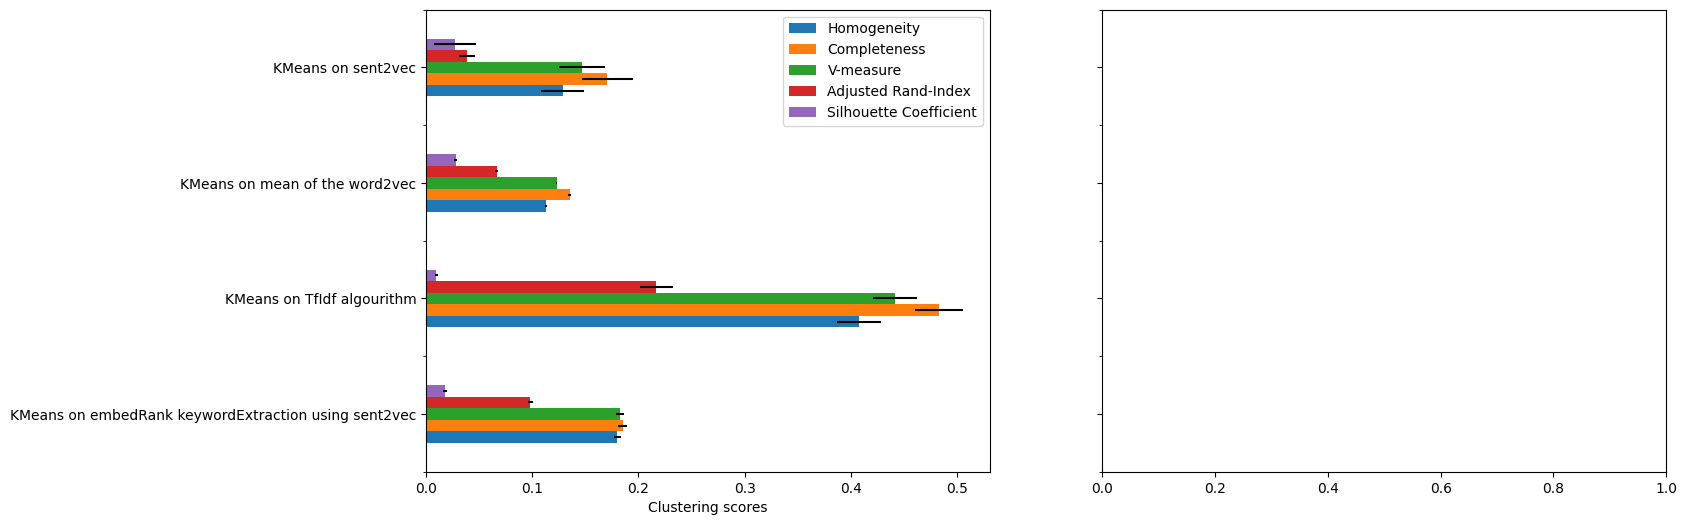

In [18]:
import pandas as pd
import matplotlib.pyplot as plt

fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(16, 6), sharey=True)

df = pd.DataFrame(evaluations[::-1]).set_index("estimator")
df_std = pd.DataFrame(evaluations_std[::-1]).set_index("estimator")

df.plot.barh(ax=ax0, xerr=df_std)
ax0.set_xlabel("Clustering scores")
ax0.set_ylabel("")


In [12]:
from hazm import Embedding, Normalizer, sent_tokenize, word_tokenize, POSTagger, PersicaReader
import nltk
import numpy as np
import pandas as pd
import warnings
from sklearn.metrics.pairwise import cosine_similarity

grammers = [
"""
NP:
        {<Ne>?<N.*>}    # Noun(s) + Noun(optional) 
        
""",

"""
NP:
        {<N.*><AJ.*>?}    # Noun(s) + Adjective(optional) 
        
"""
]

normalizer = Normalizer()

def tokenize(text):
    normalizer = Normalizer()
    return [word_tokenize(sent) for sent in sent_tokenize(normalizer.normalize(text))]

def posTagger(text ,pos_model_path = 'POStagger.model', posTaggerModel=None):
    tokens = tokenize(text)
    if posTaggerModel is None:
        tagger = POSTagger(pos_model_path)
    else:
        tagger = posTaggerModel
    return tagger.tag_sents(tokens)

def extractGrammer(tagged_text, grammer):
    keyphrase_candidate = set()
    np_parser = nltk.RegexpParser(grammer)
    trees = np_parser.parse_sents(tagged_text)
    for tree in trees:
        for subtree in tree.subtrees(filter=lambda t: t.label() == 'NP'):  # For each nounphrase
            keyphrase_candidate.add(' '.join(word for word, tag in subtree.leaves()))
    keyphrase_candidate = {kp for kp in keyphrase_candidate if len(kp.split()) <= 5}
    keyphrase_candidate = list(keyphrase_candidate)
    return keyphrase_candidate  

def extractCandidates(tagged_text, grammers = grammers):
    all_candidates = set()
    for grammer in grammers:
        all_candidates.update(extractGrammer(tagged_text, grammer))
    return np.array(list(all_candidates))
    
def text2vec(candidates, sent2vec_model_path = 'sent2vec.model', sent2vecModel=None):
    if sent2vecModel is None:
        sent2vec_model = Embedding.SentEmbedding(sent2vec_model_path)
    else:
        sent2vec_model = sent2vecModel
    candidate_vector = [[sent2vec_model[candidate] for candidate in candidates]]
    text_vector = sent2vec_model[' '.join(candidates)]
    return candidate_vector, text_vector


def vectorSimilarity(candidates_vector, text_vector, norm=True):
    candidate_sim_text = cosine_similarity(candidates_vector[0], text_vector.reshape(1,-1))
    candidate_sim_candidate = cosine_similarity(candidates_vector[0])
    if(norm):
        candidates_sim_text_norm = candidate_sim_text / np.max(candidate_sim_text)
        candidates_sim_text_norm = 0.5 + (candidates_sim_text_norm - np.average(candidates_sim_text_norm)) / np.std(candidates_sim_text_norm)
        np.fill_diagonal(candidate_sim_candidate, np.NaN)
        candidate_sim_candidate_norm = candidate_sim_candidate / np.nanmax(candidate_sim_candidate, axis=0)
        candidate_sim_candidate_norm = 0.5 + (candidate_sim_candidate_norm - np.nanmean(candidate_sim_candidate_norm, axis=0)) / np.nanstd(candidate_sim_candidate_norm, axis=0)
        return candidates_sim_text_norm, candidate_sim_candidate_norm
    return candidate_sim_text, candidate_sim_candidate


def embedRankExtraction(all_candidates, candidate_sim_text, candidate_sim_candidate, keyword_num=10, beta = 0.8):
    if(len(all_candidates)<keyword_num):
        warnings.warn(f'total number of keyword candidates is {len(all_candidates)}, which is lower than your request keyword_num')

    N = min(len(all_candidates), keyword_num)

    selected_candidates = []
    unselected_candidates = [i for i in range(len(all_candidates))]
    best_candidate = np.argmax(candidate_sim_text)
    selected_candidates.append(best_candidate)
    unselected_candidates.remove(best_candidate)

    for i in range(N-1):
        selected_vec = np.array(selected_candidates)
        unselected_vec = np.array(unselected_candidates)
        
        unselected_candidate_sim_text = candidate_sim_text[unselected_vec, :]
        
        dist_between = candidate_sim_candidate[unselected_vec][:, selected_vec]
        
        if dist_between.ndim == 1:
            dist_between = dist_between[:, np.newaxis]
        
        best_candidate = np.argmax(beta * unselected_candidate_sim_text - (1 - beta) * np.max(dist_between, axis = 1).reshape(-1,1))
        best_index = unselected_candidates[best_candidate]
        selected_candidates.append(best_index)
        unselected_candidates.remove(best_index)
    return all_candidates[selected_candidates].tolist()


def extractKeyword(candidates, keyword_num=5, sent2vecModel=None):
    candidates_vector, text_vector = text2vec(candidates, sent2vecModel=sent2vecModel)
    candidate_sim_text_norm, candidate_sim_candidate_norm = vectorSimilarity(candidates_vector, text_vector)
    return embedRankExtraction(candidates, candidate_sim_text_norm, candidate_sim_candidate_norm, keyword_num)


def embedRank(text, keyword_num, sent2vecModel=None, posTaggerModel=None):
    token_tag = posTagger(text, posTaggerModel=posTaggerModel)
    candidates = extractCandidates(token_tag)
    return extractKeyword(candidates, keyword_num, sent2vecModel=sent2vecModel)
